In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import xarray as xr
import xarray_regrid

In [2]:
precip = xr.open_dataset('data/precip_cmap.nc', decode_times=True)

# Assign the datetime values back to the DataArray if needed
precip = precip.swap_dims({'time':'T', 'lon':'X', 'lat':'Y'})
precip = precip.assign_coords(T=precip.time, X = precip.lon, Y = precip.lat)
#remove coordinate date
precip = precip.drop(['time','lat','lon'])

precip = precip.sel(X = slice(30, 62), Y = slice(40, 10))

data = precip
data['precip'] = data['precip'].transpose('T', 'Y', 'X')
#data['precip'] = data['precip'] * 30


C:\Users\emile\AppData\Local\Temp\ipykernel_16772\619840438.py:7: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  precip = precip.drop(['time','lat','lon'])


In [3]:
data

<xarray.Dataset> Size: 348kB
Dimensions:  (T: 550, Y: 12, X: 13)
Coordinates:
  * T        (T) datetime64[ns] 4kB 1979-01-01 1979-02-01 ... 2024-10-01
  * X        (X) float32 52B 31.25 33.75 36.25 38.75 ... 53.75 56.25 58.75 61.25
  * Y        (Y) float32 48B 38.75 36.25 33.75 31.25 ... 18.75 16.25 13.75 11.25
Data variables:
    precip   (T, Y, X) float32 343kB ...
Attributes:
    Conventions:    COARDS
    title:          CPC Merged Analysis of Precipitation (includes NCEP Reana...
    platform:       Analyses
    source:         ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title:  CPC Merged Analysis of Precipitation
    documentation:  https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    date_modified:  26 Feb 2019
    References:     https://www.psl.noaa.gov/data/gridded/data.cmap.html
    version:        V2411
    history:        update 11/2024 V2411
    data_modified:  2024-11-12

In [4]:
target_grid = xr.open_dataset('data/nmme_cfs.nc', decode_times=True)

#rename lat and lon to match the data
#target_grid = target_grid.rename({'latitude':'Y', 'longitude':'X'})
target_grid = target_grid.sel(X = slice(32, 60), Y = slice(12, 37))

#regrid the data
data_regrid = data.regrid.linear(target_grid)
#replace all negative values with 0
data_regrid['precip'] = data_regrid['precip'].where(data_regrid['precip'] > 0, 0)

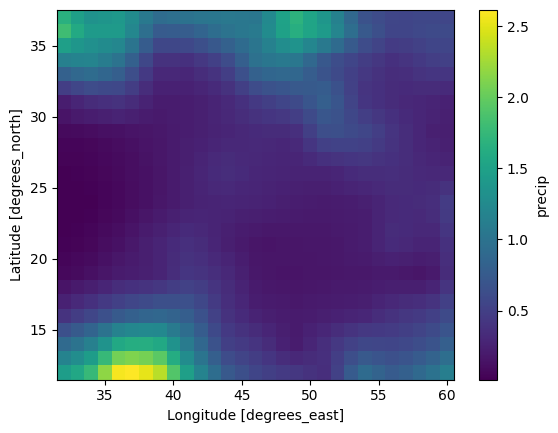

In [5]:
data_regrid.mean(dim='T').precip.plot()

In [6]:
#create variable that is the rolling sum of the next 3 months
data_regrid['rolling_sum'] = data_regrid['precip'] + data_regrid['precip'].shift(T=-1) + data_regrid['precip'].shift(T=-2)
data_regrid = data_regrid.dropna(dim='T')


In [7]:
#count the number of negative values
print('Number of negative values:', data_regrid['rolling_sum'].where(data_regrid['rolling_sum'] < 0).count().values)

Number of negative values: 0


In [10]:
x_range = data_regrid['rolling_sum'].X.values
y_range = data_regrid['rolling_sum'].Y.values
spi_list = []

for month in range(1, 13): 
    print(f"Processing month: {month}")
    #3month window modulo 12
    # months = [(month - i) % 12 if (month - i) % 12 != 0 else 12 for i in range(3)]
    data_month = data_regrid['rolling_sum'].sel(T=data_regrid['T.month']==month)
    
    T_size = len(data_month['T'])
    spi_storage = np.full((T_size, len(y_range), len(x_range)), np.nan)  # Pre-fill with NaNs

    for i, y in enumerate(y_range):
        for j, x in enumerate(x_range):
            data_grid = data_month.sel(X=x, Y=y)
            # Check if the entire grid is NaN
            if np.isnan(data_grid.values).all():
                # All values remain NaN in spi_storage
                continue

            data_grid_climo = data_grid.sel(T=slice('1991-01-01', '2020-12-01'))

            #check if 10% of the values are < 1
            if ((data_grid_climo.values < 1/30).sum() / data_grid_climo.size) > 0.1:
                continue
            else:
                # Fit pearson type III distribution to the data
                #try:
                a, loc, scale = sp.stats.pearson3.fit(data_grid.values)
                    # Calculate the CDF of the Pearson Type III distribution
                cdf_values = sp.stats.pearson3.cdf(data_grid.values, skew=a, loc=loc, scale=scale)
                q = ((np.sum(data_grid.values == 0)) / len(data_grid.values))
                cdf_values = (cdf_values*(1-q)) + q
                    #replace 0 with 1e-6
                cdf_values = np.where(cdf_values < 0.0001, 0.0001, cdf_values)
                    #replace 1 with 1-1e-6
                cdf_values = np.where(cdf_values > 0.9999, 0.9999, cdf_values)
            
                    # Convert CDF to SPI using the inverse normal distribution (PPF)
                spi_storage[:, i, j] = sp.stats.norm.ppf(cdf_values)
                #except (ValueError, RuntimeError) as e:
                    # If fitting fails, leave Nans in the SPI values
                 #   continue
    # Convert the stored SPI values into an xarray DataArray
    spi_month = xr.DataArray(spi_storage, dims=['T', 'Y', 'X'],
                    coords={'T': data_month['T'], 'Y': y_range, 'X': x_range})
    spi_list.append(spi_month)

spi = xr.concat(spi_list, dim='T')

Processing month: 1
Processing month: 2
Processing month: 3
Processing month: 4
Processing month: 5
Processing month: 6
Processing month: 7
Processing month: 8
Processing month: 9
Processing month: 10
Processing month: 11
Processing month: 12


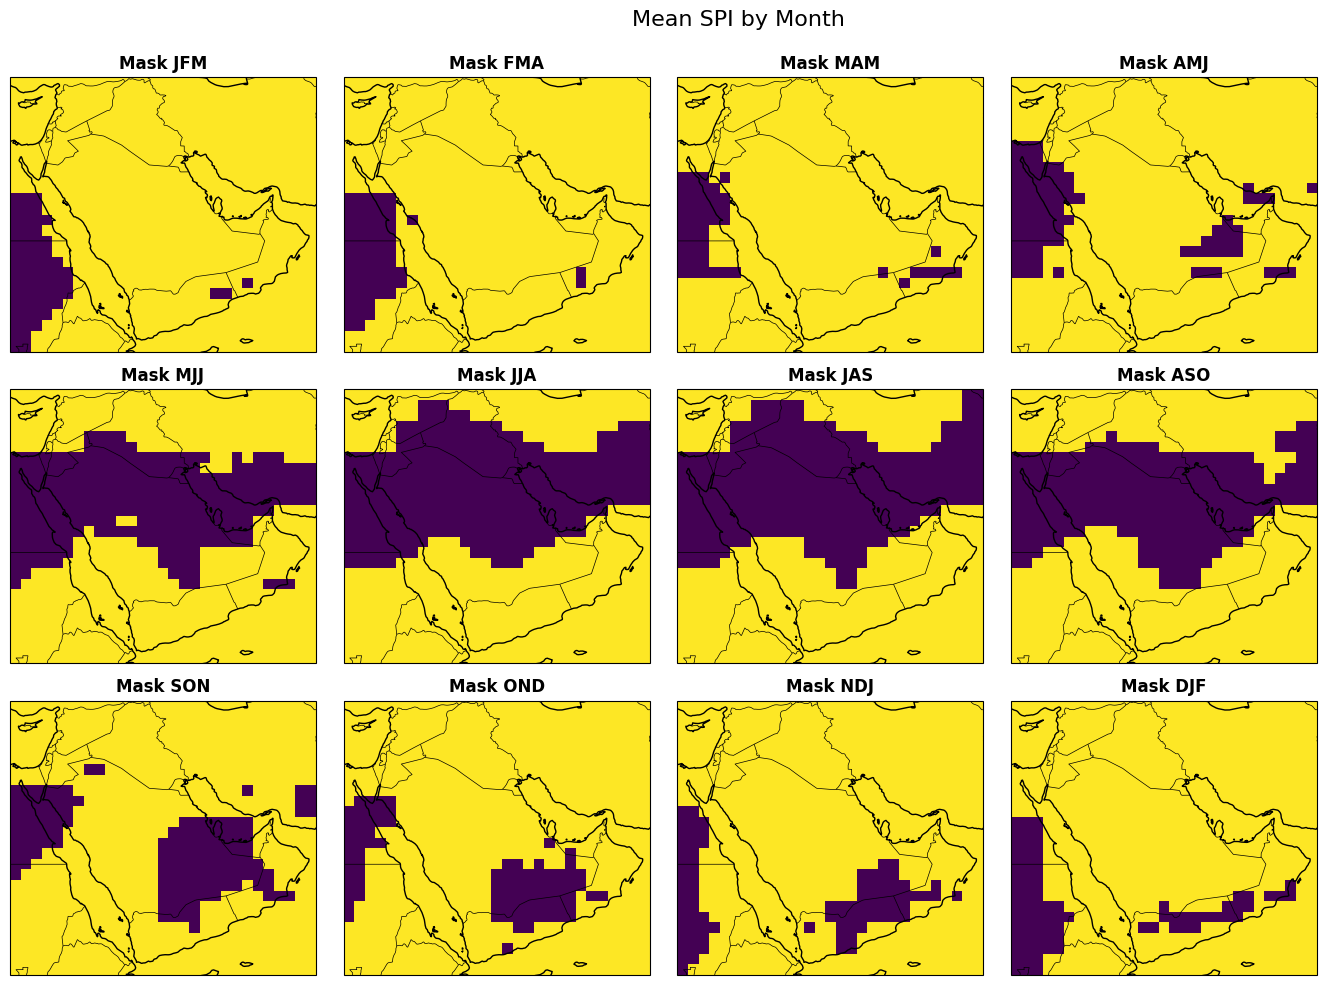

In [11]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# Calculate monthly mean SPI
spi_monthly_means = spi.groupby('T.month').mean(dim='T')
#turn into boolean 1 if not nan, 0 if nan
spi_monthly_means = spi_monthly_means.notnull().astype(int)

# Create a faceted plot with Cartopy projection
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(
    3, 4,  # 3 rows, 4 columns for the 12 months
    subplot_kw={'projection': proj},
    figsize=(15, 10)
)
axes = axes.flatten()

# Loop through months and axes
for i, (month, ax) in enumerate(zip(spi_monthly_means.month.values, axes)):
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.3)

    # Plot mean SPI for the current month
    spi_monthly_means.sel(month=month).plot(
        ax=ax,
        transform=proj,
        #levels = [-2,-1.5,-1,-0.5,0,0.5,1,1.5,2],
        #cmap='BrBG',
        add_colorbar=False,  # Disable individual colorbars
    )
    month_strings = ['JFM', 'FMA', 'MAM', 'AMJ', 'MJJ', 'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ', 'DJF']
    ax.set_title(f'Mask {month_strings[i]}', fontsize=12, fontweight='bold')

# # Add a shared colorbar
# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
# plt.colorbar(
#     axes[0].collections[0],  # Use the first plot's QuadMesh for the colorbar
#     cax=cbar_ax,
#     label='SPI'
# )

# Adjust layout and add a title
fig.tight_layout(rect=[0, 0, 0.9, 0.95])  # Make room for the shared colorbar
plt.suptitle('Mean SPI by Month', fontsize=16)

# Show the plot
plt.show()

In [12]:
save = True
if save:
    spi.to_netcdf('data/spi3_cmap_1x1.nc')

# experiment

In [11]:
point = data['rolling_sum'].sel(Y=29, X=49.75, T=data['T.month']==10)
point.plot()

KeyError: "No variable named 'rolling_sum'. Variables on the dataset include ['precip', 'T', 'X', 'Y']"

In [ ]:
((point.values < 1).sum() / len(point.values))

In [ ]:
# Simulate from the fitted gamma distribution
a, loc, scale = sp.stats.gamma.fit(point.values)
gamma_values = sp.stats.gamma.rvs(a=a, loc=loc, scale=scale, size=100)

# Calculate the CDF and SPI for gamma distribution
cdf_values = sp.stats.gamma.cdf(point.values, a=a, loc=loc, scale=scale)
q = np.sum(point.values == 0) / len(point.values)
cdf_values = (cdf_values * (1 - q)) + q
cdf_values = np.clip(cdf_values, 0.0001, 0.9999)
spi_values_gamma = sp.stats.norm.ppf(cdf_values)

# Simulate from the fitted Pearson3 distribution
a, loc, scale = sp.stats.pearson3.fit(point.values)
pearson3_values = sp.stats.pearson3.rvs(skew=a, loc=loc, scale=scale, size=100)

q = np.sum(point.values == 0) / len(point.values)
# Calculate the CDF and SPI for Pearson3 distribution
cdf_values = sp.stats.pearson3.cdf(point.values, skew=a, loc=loc, scale=scale)
cdf_values = (cdf_values * (1 - q)) + q
cdf_values = np.clip(cdf_values, 0.0001, 0.9999)
spi_values_pearson3 = sp.stats.norm.ppf(cdf_values)

# Plot histograms of gamma and Pearson3 distributions
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#Plot for gamma distribution
ax[0].hist(gamma_values, bins=10, density=True, alpha=0.5, label="Gamma Simulated")
ax[0].hist(point.values, bins=10, density=True, alpha=0.5, label="Original Data")
ax[0].set_title("Gamma Distribution")
ax[0].legend()

# Plot for Pearson3 distribution
ax[1].hist(pearson3_values, bins=10, density=True, alpha=0.5, label="Pearson3 Simulated")
ax[1].hist(point.values, bins=10, density=True, alpha=0.5, label="Original Data")
ax[1].set_title("Pearson3 Distribution")
ax[1].legend()

plt.show()


In [ ]:
plt.scatter(spi_values_pearson3,cdf_values, label='Pearson3')
plt.scatter(spi_values_gamma,cdf_values, label='Gamma')
plt.legend()

In [ ]:
plt.plot(spi_values_pearson3, label='Pearson3')
plt.plot(spi_values_gamma, label='Gamma')
plt.legend()


# add anomaly and compute correlation